In [1]:
%load_ext autoreload
%autoreload 2
from utils import load_model, get_mask
from argparse import Namespace

from dataset.dataset import SetKnowledgeTrendingSinusoids
from dataset.utils import get_dataloader
from evaluation.utils import (
    get_uncertainties,
    plot_predictions,
    get_auc_summary,
    get_summary_df,
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

plt.style.use("science")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

plt.rcParams["text.latex.preamble"] = (
    "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"
)

/home/rob/miniconda3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the models
save_dirs = {
    "NP": "../saves/INPs_sinusoids/np_1",
    "INP": "../saves/INPs_sinusoids/inp_abc2_1",
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(
        save_dir, load_it="best"
    )
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/INPs_sinusoids/np_1
../saves/INPs_sinusoids/inp_abc2_1


In [3]:
# Setup the dataloaders
config = Namespace(
    min_num_context=0,
    max_num_context=100,
    num_targets=100,
    noise=0.2,
    batch_size=32,
    x_sampler="uniform",
    test_num_z_samples=32,
    dataset="set-trending-sinusoids",
    device="cuda:0",
)

dataset = SetKnowledgeTrendingSinusoids(
    root="../data/trending-sinusoids", split="test", knowledge_type="full"
)
data_loader = get_dataloader(dataset, config)

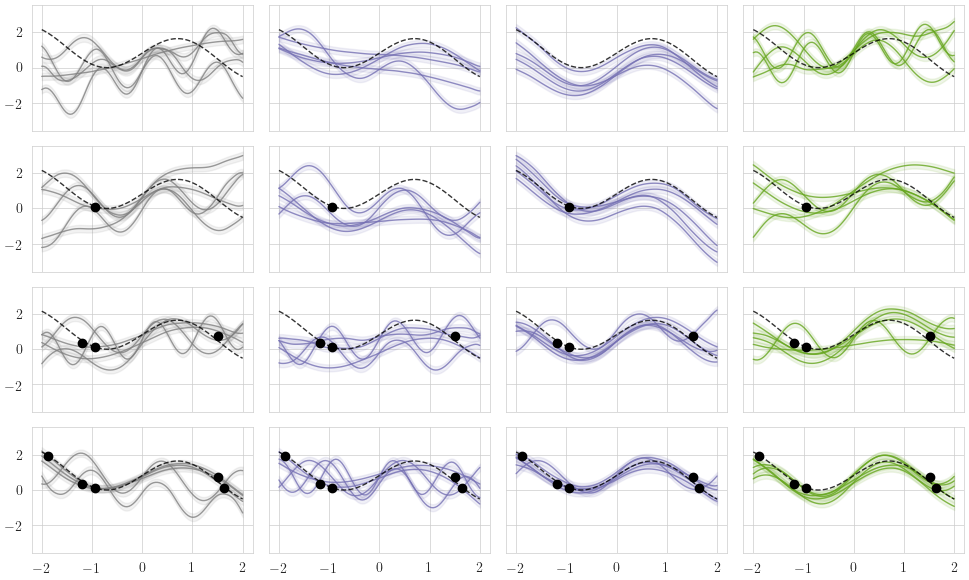

In [4]:
# Plot sample predictions

for batch in data_loader:
    (x_context, y_context), (x_target, y_target), full_knowledge, extras = batch
    x_context = x_context.to(config.device)
    y_context = y_context.to(config.device)
    x_target = x_target.to(config.device)
    y_target = y_target.to(config.device)


num_context_ls = [0, 1, 3, 5]
sample_idx = np.random.choice(list(range(x_target.shape[-2])), max(num_context_ls))
batch_idx = 0

fig, axs = plt.subplots(
    len(num_context_ls), 4, figsize=(10, 6), sharex=True, sharey=True
)

colors = {"raw": "grey", "a": "C2", "b": "C2", "c": "C4"}

for j, knowledge_type in enumerate(["raw", "a", "b", "c"]):
    if knowledge_type == "raw":
        knowledge = None
    else:
        mask = get_mask(knowledge_type)
        knowledge = full_knowledge * mask

    for i, num_context in enumerate(num_context_ls):
        x_context = x_target[:, sample_idx[:num_context], :]
        y_context = y_target[:, sample_idx[:num_context], :]

        with torch.no_grad():
            INP_outupts = model_dict["INP"](
                x_context, y_context, x_target, y_target=y_target, knowledge=knowledge
            )

        plot_predictions(
            axs[i][j],
            batch_idx,
            INP_outupts,
            x_context,
            y_context,
            x_target,
            extras,
            color=colors[knowledge_type],
            plot_true=True,
        )
plt.tight_layout()
plt.show()

In [5]:
# Evaluate the models on different knowledge types
eval_type_ls = ["raw", "informed", "a", "b", "c", "ab", "bc", "ac"]

summary_df, losses, outputs_dict = get_summary_df(
    model_dict, config_dict, data_loader, eval_type_ls, model_names
)

summary_df["print_value"] = summary_df["mean"].apply(
    lambda x: f"{x:.1f}"
)  # + ' \scriptsize{(' + summary_df['std'].apply(lambda x: f'{x:.1f}') + ')}'
print_df = (
    summary_df.dropna(subset=["mean"])
    .pivot(
        columns="num_context", index=["model_name", "eval_type"], values=["print_value"]
    )
    .T.round(2)
)

print_df.droplevel(0, axis=0).dropna(axis=1, how="all")

model_name     INP                                                     NP
eval_type        a    ab     ac     b    bc      c informed    raw    raw
num_context                                                              
0            228.3  36.7   72.9  90.5  36.8  153.9      8.4  301.2  319.8
1            179.2  45.0  122.8  67.6  45.2  153.8     30.9  231.8  215.1
3             69.1   9.3   53.3  14.5   9.8   76.1      7.4   85.4  101.2
5             40.8   1.7   33.4   3.5   2.9   43.2      1.7   48.8   54.1
10             6.3  -6.3    5.6  -6.1  -6.5    7.7     -6.5   10.4   16.6
15             0.3  -8.7   -1.1  -8.4  -8.9    0.4     -8.7    2.0    7.8

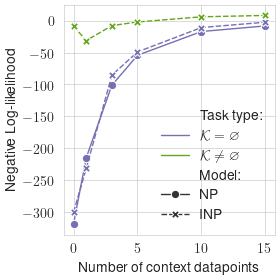

In [6]:
plot_df = (
    summary_df[
        (summary_df.model_name.isin(["INP", "NP"]))
        & (summary_df.eval_type.isin(["raw", "informed"]))
    ]
    .copy()
    .reset_index(drop=True)
)
plot_df["mean"] = -plot_df["mean"]
plot_df["eval_type"] = plot_df["eval_type"].map(
    {
        "raw": r"$\mathcal{K} = \varnothing$",
        "informed": r"$\mathcal{K} \neq \varnothing$",
    }
)


fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(
    plot_df,
    x="num_context",
    y="mean",
    hue="eval_type",
    style="model_name",
    palette=["C2", "C4"],
    ax=ax,
    style_order=["NP", "INP"],
    markers=True,
)

ax.set_ylabel("Negative Log-likelihood")
ax.set_xlabel("Number of context datapoints")

handles, labels = ax.get_legend_handles_labels()

labels[0] = "Task type:"
labels[3] = "Model:"

plt.legend(labels=labels, handles=handles)
plt.tight_layout()
# plt.savefig('../figures/exp-1.pdf')
plt.show()

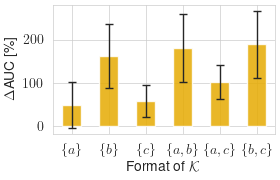

In [7]:
# Delta-AUC
model_name = "INP"

eval_type_ls = ["a", "b", "c", "ab", "ac", "bc"]
num_context_ls = [0, 1, 3, 5, 10, 15]

auc_summary, _ = get_auc_summary(losses, model_name, eval_type_ls, num_context_ls)

auc_df = (pd.DataFrame(auc_summary).T * 100).round(1)
auc_df.columns = ["mean", "se"]
# plot bar chart with error bars
fig, ax = plt.subplots(figsize=(3, 2))
auc_df["mean"].plot.bar(yerr=auc_df["se"], ax=ax, capsize=3, color="C5", alpha=0.85)
ax.set_ylabel("$\Delta$AUC [\%]")
ax.set_xlabel("Format of $\mathcal{K}$")
ax.set_xticklabels(
    ["$\\{%s\\}$" % ", ".join(list(k)) for k in auc_df.index], rotation=0
)
plt.tight_layout()
# plt.savefig('../figures/sinusoid_auc.pdf', bbox_inches='tight')
plt.show()

In [8]:
knowledge_type_ls = ["raw", "informed", "a", "b", "c"]
num_context_ls = [0, 1]

uncertainties = get_uncertainties(
    outputs_dict, num_context_ls, knowledge_type_ls, model_name="INP", n_batches=30
)

num_context: 0 eval_type: raw


100%|██████████| 30/30 [00:02<00:00, 11.48it/s]


num_context: 0 eval_type: informed


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


num_context: 0 eval_type: a


100%|██████████| 30/30 [00:02<00:00, 11.95it/s]


num_context: 0 eval_type: b


100%|██████████| 30/30 [00:02<00:00, 11.68it/s]


num_context: 0 eval_type: c


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


num_context: 1 eval_type: raw


100%|██████████| 30/30 [00:02<00:00, 13.16it/s]


num_context: 1 eval_type: informed


100%|██████████| 30/30 [00:02<00:00, 12.88it/s]


num_context: 1 eval_type: a


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


num_context: 1 eval_type: b


100%|██████████| 30/30 [00:02<00:00, 13.02it/s]


num_context: 1 eval_type: c


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


/tmp/ipykernel_438852/4069030990.py:102: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  .legendHandles


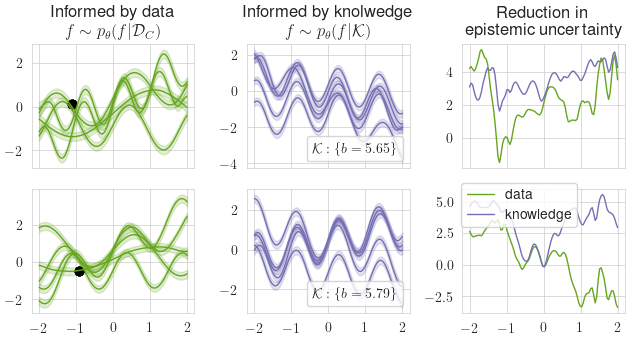

In [9]:
num_context = 1
idx_ls = [("b", 0, 0)] + [("b", 3, 3)]

fig, axs = plt.subplots(len(idx_ls), 3, figsize=(6.5, 1.8 * len(idx_ls)), sharex=True)

model_name = "INP"
uncert_type = "epistemic"

for i, (knowledge_type, batch_idx, in_batch_idx) in enumerate(idx_ls):
    uncert_reduction_knowledge = (
        uncertainties[0]["raw"][batch_idx][uncert_type]
        - uncertainties[0][knowledge_type][batch_idx][uncert_type]
    )
    uncert_reduction_data = (
        uncertainties[0]["raw"][batch_idx][uncert_type]
        - uncertainties[num_context]["raw"][batch_idx][uncert_type]
    )

    for sample_id in range(5):
        eval_type = "raw"
        mu = (
            outputs_dict[model_name][eval_type][num_context][batch_idx]["outputs"][0]
            .mean[:, :, :]
            .cpu()
        )
        sigma = (
            outputs_dict[model_name][eval_type][num_context][batch_idx]["outputs"][0]
            .stddev[:, :, :]
            .cpu()
        )
        x_context = outputs_dict[model_name][eval_type][num_context][batch_idx][
            "x_context"
        ]
        y_context = outputs_dict[model_name][eval_type][num_context][batch_idx][
            "y_context"
        ]
        x_target = outputs_dict[model_name][eval_type][num_context][batch_idx][
            "x_target"
        ]
        y_target = outputs_dict[model_name][eval_type][num_context][batch_idx][
            "y_target"
        ]
        # axs[i][0].plot(x_target[in_batch_idx, :].flatten(), y_target[in_batch_idx, :], color='black', linestyle='--')
        axs[i][0].plot(
            x_target[in_batch_idx, :].flatten(),
            mu[sample_id, in_batch_idx, :].flatten(),
            color="C4",
        )
        axs[i][0].fill_between(
            x_target[in_batch_idx, :].flatten(),
            (
                mu[sample_id, in_batch_idx, :] - sigma[sample_id, in_batch_idx, :]
            ).flatten(),
            (
                mu[sample_id, in_batch_idx, :] + sigma[sample_id, in_batch_idx, :]
            ).flatten(),
            alpha=0.2,
            color="C4",
        )
        axs[i][0].scatter(
            x_context[in_batch_idx, :].flatten(),
            y_context[in_batch_idx, :].flatten(),
            color="black",
        )

        eval_type = knowledge_type
        mu = (
            outputs_dict[model_name][eval_type][0][batch_idx]["outputs"][0]
            .mean[:, :, :]
            .cpu()
        )
        sigma = (
            outputs_dict[model_name][eval_type][0][batch_idx]["outputs"][0]
            .stddev[:, :, :]
            .cpu()
        )
        x_context = outputs_dict[model_name][eval_type][0][batch_idx]["x_context"]
        y_context = outputs_dict[model_name][eval_type][0][batch_idx]["y_context"]
        x_target = outputs_dict[model_name][eval_type][0][batch_idx]["x_target"]
        # axs[i][1].plot(x_target[in_batch_idx, :].flatten(), y_target[in_batch_idx, :], color='black', linestyle='--')
        axs[i][1].scatter(
            x_context[in_batch_idx, :].flatten(),
            y_context[in_batch_idx, :].flatten(),
            color="black",
        )
        knowledge_value = outputs_dict[model_name][eval_type][0][batch_idx]["knowledge"]
        knowledge_value = (knowledge_value[in_batch_idx, :] * get_mask(knowledge_type))[
            :, 3
        ]
        knowledge_value = knowledge_value[knowledge_value != 0].item()
        label = "$\mathcal{K}: \{" + f"{knowledge_type} = {knowledge_value:.2f}" + "\}$"

        axs[i][1].plot(
            x_target[in_batch_idx, :].flatten(),
            mu[sample_id, in_batch_idx, :].flatten(),
            color="C2",
            label=None if sample_id > 0 else label,
        )
        for item in (
            axs[i][1]
            .legend(handlelength=0, handletextpad=0, loc="lower right", frameon=True)
            .legendHandles
        ):
            item.set_visible(False)
        axs[i][1].fill_between(
            x_target[in_batch_idx, :].flatten(),
            (
                mu[sample_id, in_batch_idx, :] - sigma[sample_id, in_batch_idx, :]
            ).flatten(),
            (
                mu[sample_id, in_batch_idx, :] + sigma[sample_id, in_batch_idx, :]
            ).flatten(),
            alpha=0.2,
            color="C2",
        )
    axs[i][2].plot(
        x_target[in_batch_idx, :].flatten(),
        uncert_reduction_data[in_batch_idx, :],
        label="data",
        color="C4",
    )
    axs[i][2].plot(
        x_target[in_batch_idx, :].flatten(),
        uncert_reduction_knowledge[in_batch_idx, :],
        label="knowledge",
        color="C2",
    )

axs[0][0].set_title("Informed by data \n" + r"$f \sim p_\theta(f | \mathcal{D}_C)$")
axs[0][1].set_title("Informed by knolwedge \n" + r"$f \sim p_\theta(f | \mathcal{K})$")
axs[0][2].set_title("Reduction in \n epistemic uncertainty")
axs[1][2].legend(loc="upper left", bbox_to_anchor=(-0.05, 1.1), frameon=True)


for i in range(3):
    axs[0][i].set_xticks([-2, -1, 0, 1, 2])

plt.tight_layout()
# plt.savefig('../figures/uncertainty-trending-sinusoids.pdf', bbox_inches='tight')
plt.show()